In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import gc
import joblib
import re
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_auc_score,
                           roc_curve, classification_report,
                           precision_recall_curve, average_precision_score)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Dense, Dropout,
                                   LayerNormalization, MultiHeadAttention,
                                   GlobalAveragePooling1D, Add, Concatenate)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint, TensorBoard)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df = pd.read_csv('Modified_SQL_Dataset.csv')
df.head(10)

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 temporary tablespace temp default tablespace users;,1
2,AND 1 = utl_inaddr.get_host_address ( ( SELECT DISTINCT ( table_name ) FROM ( ...,1
3,"select * from users where id = '1' or @ @1 = 1 union select 1,version ( ) -- 1'",1
4,"select * from users where id = 1 or 1#"" ( union select 1,version ( ) -- 1",1
5,select name from syscolumns where id = ( select id from sysobjects where name = tabl...,1
6,select * from users where id = 1 +$+ or 1 = 1 -- 1,1
7,"1; ( load_file ( char ( 47,101,116,99,47,112,97,115,115,119,100 ) ) ) ,1,1,1;",1
8,"select * from users where id = '1' or ||/1 = 1 union select 1,version ( ) -- 1'",1
9,"select * from users where id = '1' or \.<\ union select 1,@@VERSION -- 1'",1


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30919 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


,Label
count,30919.0000
mean,0.3681
std,0.4823
min,0.0000
25%,0.0000
50%,0.0000
75%,1.0000
max,1.0000


In [5]:
print(f"Dataset Shape: {df.shape}")
print(f"\nColumn Names: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

Dataset Shape: (30919, 2)

Column Names: ['Query', 'Label']

Data Types:
Query    object
Label     int64
dtype: object

Missing Values:
Query    0
Label    0
dtype: int64

Duplicate Rows: 12


In [6]:
print("\nLabel Distribution:")
print(df['Label'].value_counts())
print(f"\nLabel Percentage:")
print(df['Label'].value_counts(normalize=True) * 100)


Label Distribution:
Label
0    19537
1    11382
Name: count, dtype: int64

Label Percentage:
Label
0   63.1877
1   36.8123
Name: proportion, dtype: float64


In [7]:
df['Query_Length'] = df['Query'].astype(str).apply(len)
df['Word_Count'] = df['Query'].astype(str).apply(lambda x: len(x.split()))
df['Special_Char_Count'] = df['Query'].astype(str).apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))
df['Digit_Count'] = df['Query'].astype(str).apply(lambda x: sum(c.isdigit() for c in x))

print("\nQuery Statistics:")
print(df[['Query_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count']].describe())


Query Statistics:
       Query_Length  Word_Count  Special_Char_Count  Digit_Count
count    30919.0000  30919.0000          30919.0000   30919.0000
mean        68.8829     12.4145              7.9709       7.8400
std         81.1450     14.9285             12.3399      13.3314
min          1.0000      0.0000              0.0000       0.0000
25%         21.0000      4.0000              1.0000       0.0000
50%         48.0000      9.0000              4.0000       2.0000
75%         81.0000     14.0000             10.0000       9.0000
max       5370.0000    216.0000            595.0000     641.0000


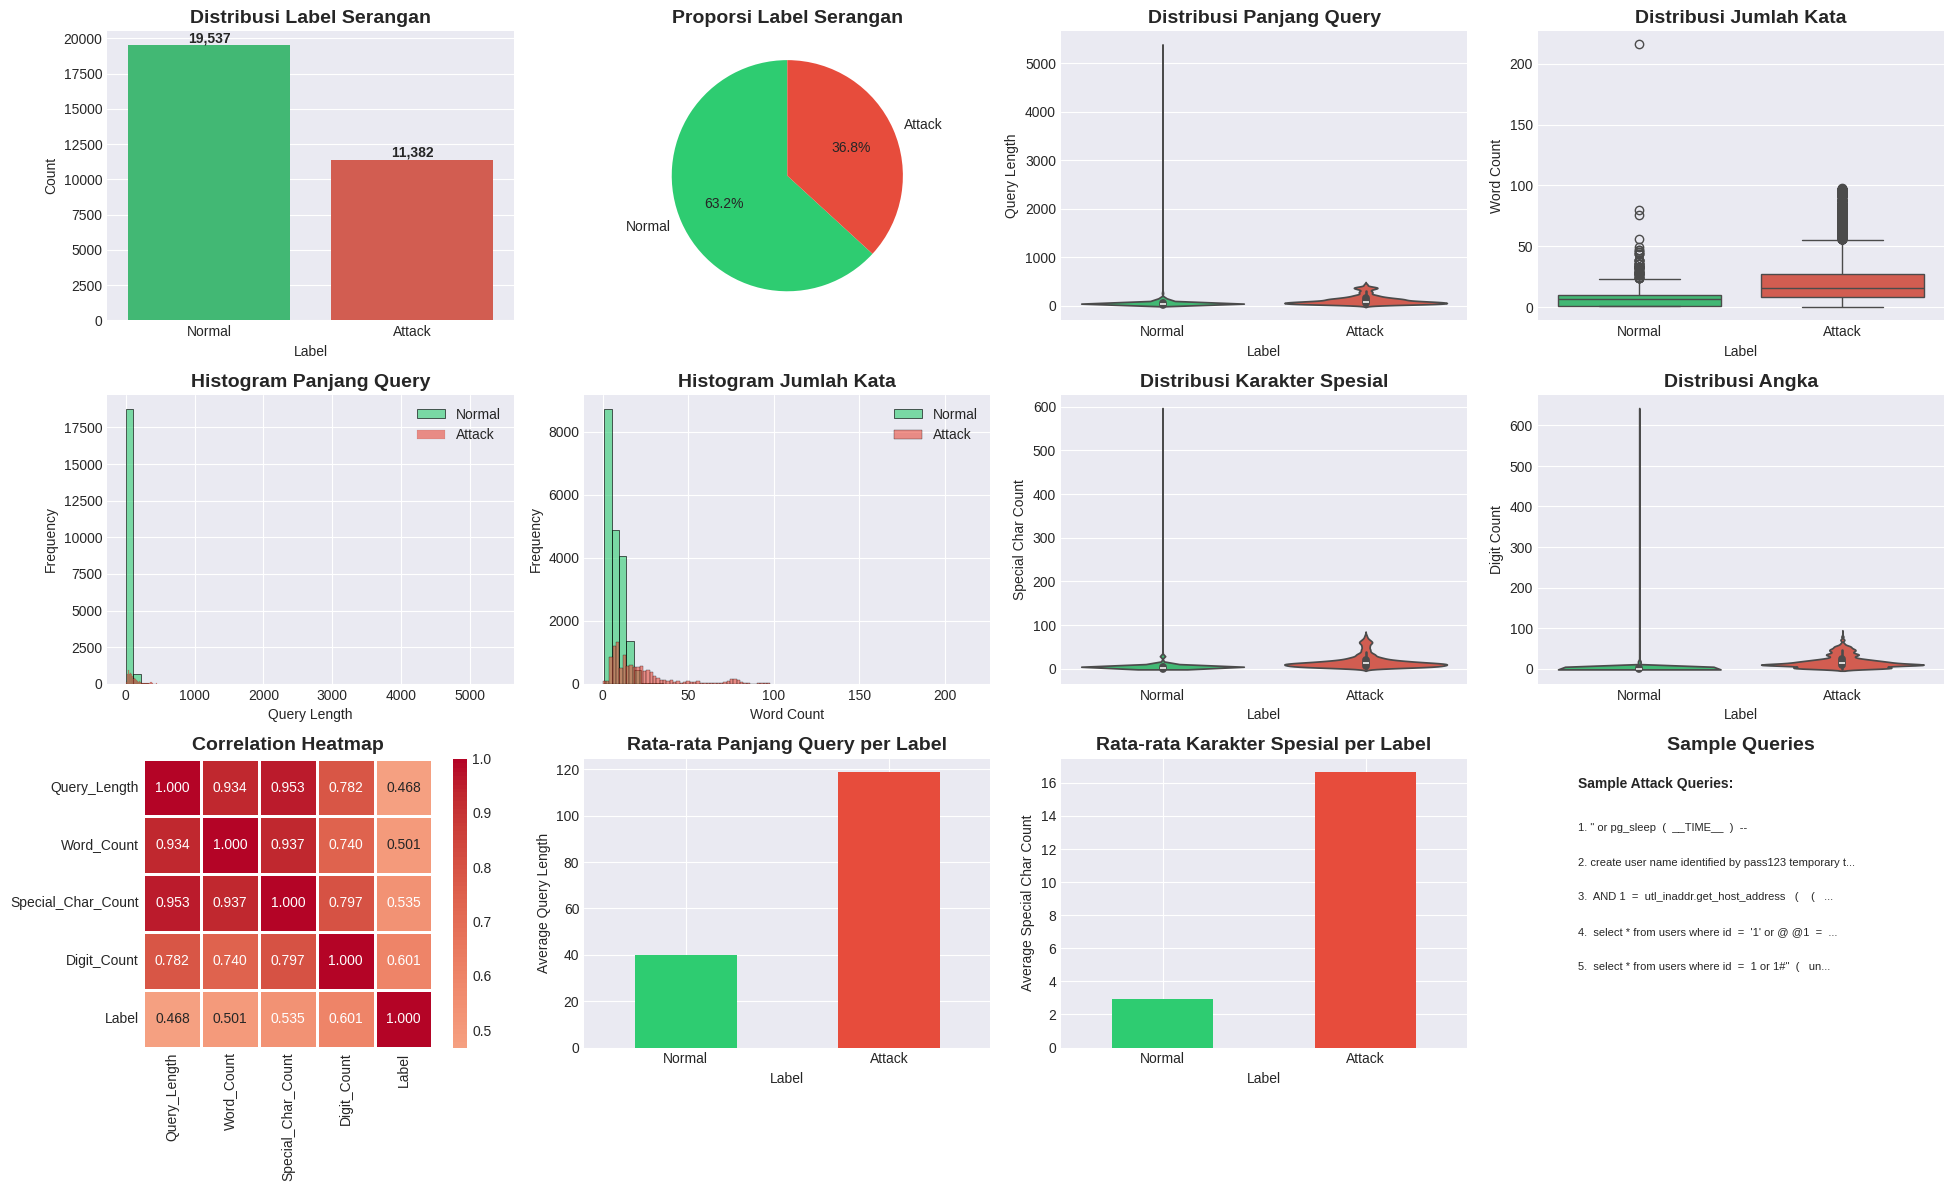

In [8]:
plt.figure(figsize=(20, 12))

plt.subplot(3, 4, 1)
sns.countplot(data=df, x='Label', palette=['#2ecc71', '#e74c3c'])
plt.title('Distribusi Label Serangan', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'Attack'])
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontweight='bold')

plt.subplot(3, 4, 2)
df['Label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'],
    labels=['Normal', 'Attack'],
    startangle=90
)
plt.title('Proporsi Label Serangan', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.subplot(3, 4, 3)
sns.violinplot(data=df, x='Label', y='Query_Length', palette=['#2ecc71', '#e74c3c'])
plt.title('Distribusi Panjang Query', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Query Length')
plt.xticks([0, 1], ['Normal', 'Attack'])

plt.subplot(3, 4, 4)
sns.boxplot(data=df, x='Label', y='Word_Count', palette=['#2ecc71', '#e74c3c'])
plt.title('Distribusi Jumlah Kata', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Word Count')
plt.xticks([0, 1], ['Normal', 'Attack'])

plt.subplot(3, 4, 5)
sns.histplot(data=df[df['Label']==0], x='Query_Length', bins=50, color='#2ecc71', alpha=0.6, label='Normal')
sns.histplot(data=df[df['Label']==1], x='Query_Length', bins=50, color='#e74c3c', alpha=0.6, label='Attack')
plt.title('Histogram Panjang Query', fontsize=14, fontweight='bold')
plt.xlabel('Query Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3, 4, 6)
sns.histplot(data=df[df['Label']==0], x='Word_Count', bins=50, color='#2ecc71', alpha=0.6, label='Normal')
sns.histplot(data=df[df['Label']==1], x='Word_Count', bins=50, color='#e74c3c', alpha=0.6, label='Attack')
plt.title('Histogram Jumlah Kata', fontsize=14, fontweight='bold')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3, 4, 7)
sns.violinplot(data=df, x='Label', y='Special_Char_Count', palette=['#2ecc71', '#e74c3c'])
plt.title('Distribusi Karakter Spesial', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Special Char Count')
plt.xticks([0, 1], ['Normal', 'Attack'])

plt.subplot(3, 4, 8)
sns.violinplot(data=df, x='Label', y='Digit_Count', palette=['#2ecc71', '#e74c3c'])
plt.title('Distribusi Angka', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Digit Count')
plt.xticks([0, 1], ['Normal', 'Attack'])

plt.subplot(3, 4, 9)
correlation = df[['Query_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count', 'Label']].corr()
sns.heatmap(correlation, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')

plt.subplot(3, 4, 10)
df.groupby('Label')['Query_Length'].mean().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Rata-rata Panjang Query per Label', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Average Query Length')
plt.xticks([0, 1], ['Normal', 'Attack'], rotation=0)

plt.subplot(3, 4, 11)
df.groupby('Label')['Special_Char_Count'].mean().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Rata-rata Karakter Spesial per Label', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Average Special Char Count')
plt.xticks([0, 1], ['Normal', 'Attack'], rotation=0)

plt.subplot(3, 4, 12)
sample_queries_attack = df[df['Label']==1]['Query'].head(5).tolist()
sample_queries_normal = df[df['Label']==0]['Query'].head(5).tolist()
plt.text(0.1, 0.9, 'Sample Attack Queries:', fontsize=10, fontweight='bold', transform=plt.gca().transAxes)
for i, q in enumerate(sample_queries_attack):
    q_short = q[:50] + '...' if len(q) > 50 else q
    plt.text(0.1, 0.75 - i*0.12, f"{i+1}. {q_short}", fontsize=8, transform=plt.gca().transAxes, wrap=True)
plt.axis('off')
plt.title('Sample Queries', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

df['Query_Cleaned'] = df['Query'].apply(clean_text)

print("Sample Cleaned Queries:")
for i in range(5):
    print(f"\nOriginal: {df['Query'].iloc[i]}")
    print(f"Cleaned:  {df['Query_Cleaned'].iloc[i]}")

Sample Cleaned Queries:

Original: " or pg_sleep  (  __TIME__  )  --
Cleaned:  " or pg_sleep ( __time__ ) --

Original: create user name identified by pass123 temporary tablespace temp default tablespace users;
Cleaned:  create user name identified by pass123 temporary tablespace temp default tablespace users;

Original:  AND 1  =  utl_inaddr.get_host_address   (    (   SELECT DISTINCT  (  table_name  )   FROM   (  SELECT DISTINCT  (  table_name  )  , ROWNUM AS LIMIT FROM sys.all_tables  )   WHERE LIMIT  =  5   )    )    AND 'i'  =  'i
Cleaned:  and 1 = utl_inaddr.get_host_address ( ( select distinct ( table_name ) from ( select distinct ( table_name ) , rownum as limit from sys.all_tables ) where limit = 5 ) ) and 'i' = 'i

Original:  select * from users where id  =  '1' or @ @1  =  1 union select 1,version  (    )   -- 1'
Cleaned:  select * from users where id = '1' or @ @1 = 1 union select 1,version ( ) -- 1'

Original:  select * from users where id  =  1 or 1#"  (   union select 1,

In [10]:
X = df['Query_Cleaned'].values
y = df['Label'].values

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

In [11]:
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Validation Set: {X_val.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")

print(f"\nTraining Label Distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nValidation Label Distribution:")
print(pd.Series(y_val).value_counts())
print(f"\nTest Label Distribution:")
print(pd.Series(y_test).value_counts())

Training Set: 21643 samples
Validation Set: 3092 samples
Test Set: 6184 samples

Training Label Distribution:
0    13675
1     7968
Name: count, dtype: int64

Validation Label Distribution:
0    1954
1    1138
Name: count, dtype: int64

Test Label Distribution:
0    3908
1    2276
Name: count, dtype: int64


In [12]:
MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>', char_level=False)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [13]:
print(f"Vocabulary Size: {len(tokenizer.word_index)}")
print(f"Training Shape: {X_train_pad.shape}")
print(f"Validation Shape: {X_val_pad.shape}")
print(f"Test Shape: {X_test_pad.shape}")

print("\nSample Tokenized Sequence:")
print(f"Original: {X_train[0]}")
print(f"Tokenized: {X_train_seq[0][:20]}...")
print(f"Padded Shape: {X_train_pad[0].shape}")

Vocabulary Size: 22267
Training Shape: (21643, 100)
Validation Shape: (3092, 100)
Test Shape: (6184, 100)

Sample Tokenized Sequence:
Original: 1 ) where 2044 = 2044 or elt ( 6272 = 6272,sleep ( 5 ) ) --
Tokenized: [4, 5, 4874, 4874, 11, 36, 291, 291, 34, 28]...
Padded Shape: (100,)


In [14]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [15]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [16]:
def create_transformer_model(vocab_size, maxlen, embed_dim=128, num_heads=4, ff_dim=256, num_transformer_blocks=2, dropout_rate=0.1):
    inputs = Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x, training=True)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
VOCAB_SIZE = min(len(tokenizer.word_index) + 1, MAX_WORDS)
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 256
NUM_TRANSFORMER_BLOCKS = 2
DROPOUT_RATE = 0.2

transformer_model = create_transformer_model(
    vocab_size=VOCAB_SIZE,
    maxlen=MAX_LEN,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    dropout_rate=DROPOUT_RATE
)

transformer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 100, 128)       │     1,292,800 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 100, 128)       │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 100, 128)       │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,978,113 (7.55 MB)

 Trainable params: 1,978,113 (7.55 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
class_weights = {
    0: len(y_train) / (2 * np.sum(y_train == 0)),
    1: len(y_train) / (2 * np.sum(y_train == 1))
}

print(f"Class Weights: {class_weights}")

Class Weights: {0: np.float64(0.7913345521023766), 1: np.float64(1.3581199799196788)}


In [19]:
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

def balanced_accuracy(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    sensitivity = tp / (tp + fn + K.epsilon())
    specificity = tn / (tn + fp + K.epsilon())
    return (sensitivity + specificity) / 2

In [20]:
transformer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc'),
             f1_metric,
             balanced_accuracy]
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    mode='max',
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_transformer_model.keras',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [21]:
callbacks = [early_stopping, reduce_lr, model_checkpoint]

history = transformer_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7936 - auc: 0.8683 - balanced_accuracy: 0.2603 - f1_metric: 0.2215 - loss: 1.4283 - precision: 0.7045 - recall: 0.8115
Epoch 1: val_auc improved from -inf to 0.99620, saving model to best_transformer_model.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.7939 - auc: 0.8686 - balanced_accuracy: 0.2603 - f1_metric: 0.2214 - loss: 1.4262 - precision: 0.7049 - recall: 0.8119 - val_accuracy: 0.9948 - val_auc: 0.9962 - val_balanced_accuracy: 0.2711 - val_f1_metric: 0.2006 - val_loss: 0.0950 - val_precision: 0.9938 - val_recall: 0.9921 - learning_rate: 0.0010
Epoch 2/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9911 - auc: 0.9940 - balanced_accuracy: 0.2701 - f1_metric: 0.2033 - loss: 0.0935 - precision: 0.9886 - recall: 0.9874
Epoch 2: val_auc improved from 0.99620 to 0.99702, saving model to best_transformer_model.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9911 - auc: 0.9940 - b

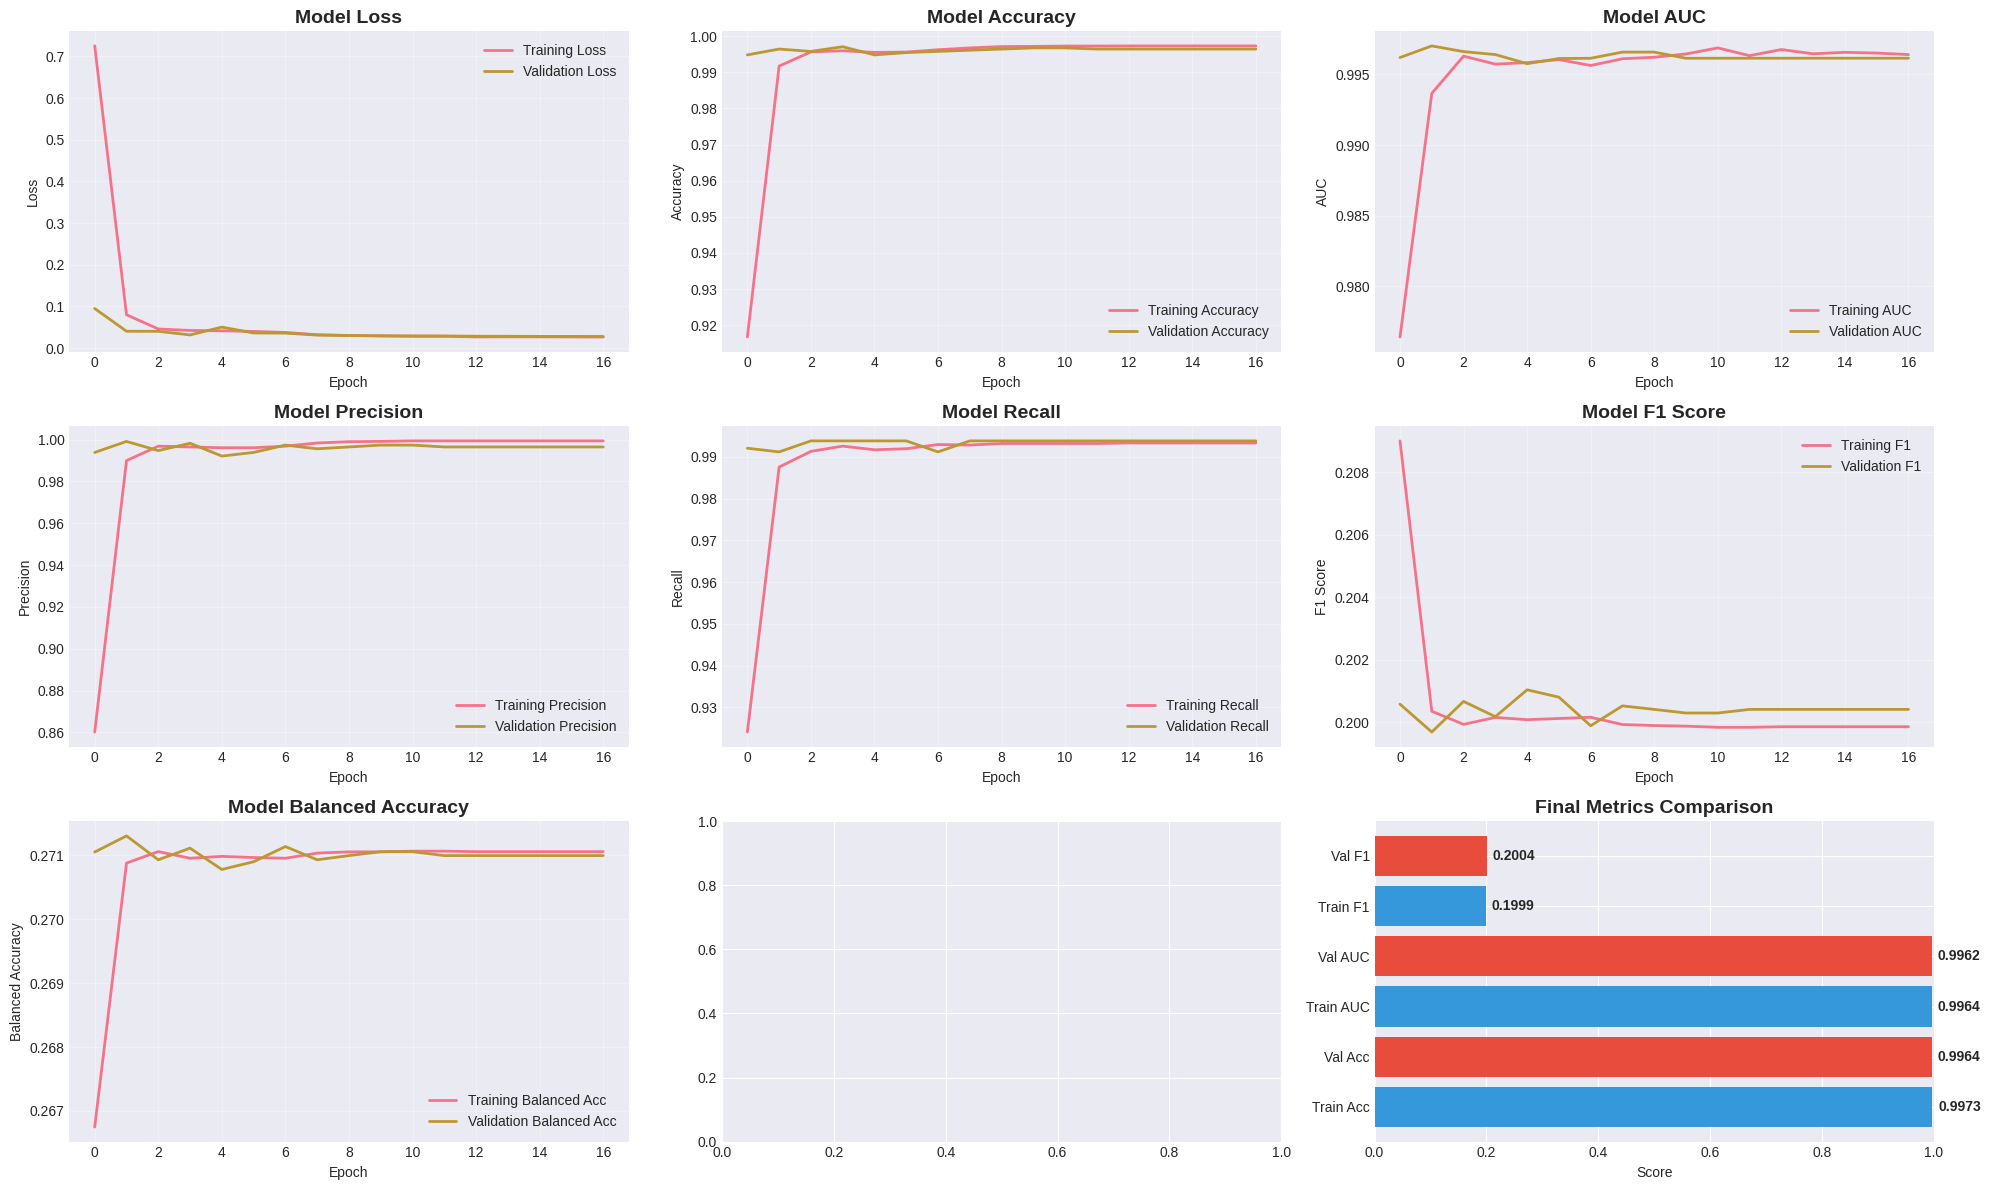

In [22]:
plt.figure(figsize=(20, 12))

plt.subplot(3, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 3)
plt.plot(history.history['auc'], label='Training AUC', linewidth=2)
plt.plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
plt.title('Model AUC', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 4)
plt.plot(history.history['precision'], label='Training Precision', linewidth=2)
plt.plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
plt.title('Model Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 5)
plt.plot(history.history['recall'], label='Training Recall', linewidth=2)
plt.plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
plt.title('Model Recall', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 6)
plt.plot(history.history['f1_metric'], label='Training F1', linewidth=2)
plt.plot(history.history['val_f1_metric'], label='Validation F1', linewidth=2)
plt.title('Model F1 Score', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 7)
plt.plot(history.history['balanced_accuracy'], label='Training Balanced Acc', linewidth=2)
plt.plot(history.history['val_balanced_accuracy'], label='Validation Balanced Acc', linewidth=2)
plt.title('Model Balanced Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 8)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2, color='purple')
    plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 9)
final_metrics = {
    'Train Acc': history.history['accuracy'][-1],
    'Val Acc': history.history['val_accuracy'][-1],
    'Train AUC': history.history['auc'][-1],
    'Val AUC': history.history['val_auc'][-1],
    'Train F1': history.history['f1_metric'][-1],
    'Val F1': history.history['val_f1_metric'][-1]
}
metrics_df = pd.DataFrame(list(final_metrics.items()), columns=['Metric', 'Value'])
plt.barh(metrics_df['Metric'], metrics_df['Value'], color=['#3498db', '#e74c3c', '#3498db', '#e74c3c', '#3498db', '#e74c3c'])
plt.title('Final Metrics Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Score')
plt.xlim(0, 1)
for i, v in enumerate(metrics_df['Value']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [23]:
y_pred_proba_val = transformer_model.predict(X_val_pad).flatten()
y_pred_proba_test = transformer_model.predict(X_test_pad).flatten()

precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_pred_proba_val)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"F1 Score at Optimal Threshold: {f1_scores[optimal_idx]:.4f}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Optimal Threshold: 0.3277
F1 Score at Optimal Threshold: 0.9965


In [24]:
y_pred_val = (y_pred_proba_val >= optimal_threshold).astype(int)
y_pred_test = (y_pred_proba_test >= optimal_threshold).astype(int)

def evaluate_model_comprehensive(y_true, y_pred, y_pred_proba, dataset_name):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'average_precision': average_precision_score(y_true, y_pred_proba)
    }

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['balanced_accuracy'] = (metrics['sensitivity'] + metrics['specificity']) / 2

    print(f"{dataset_name} SET EVALUATION RESULTS")
    print(f"Accuracy:           {metrics['accuracy']:.4f}")
    print(f"Precision:          {metrics['precision']:.4f}")
    print(f"Recall:             {metrics['recall']:.4f}")
    print(f"F1 Score:           {metrics['f1_score']:.4f}")
    print(f"ROC-AUC:            {metrics['roc_auc']:.4f}")
    print(f"Average Precision:  {metrics['average_precision']:.4f}")
    print(f"Sensitivity:        {metrics['sensitivity']:.4f}")
    print(f"Specificity:        {metrics['specificity']:.4f}")
    print(f"Balanced Accuracy:  {metrics['balanced_accuracy']:.4f}")

    print(f"Confusion Matrix:")
    print(f"TN: {tn}  FP: {fp}")
    print(f"FN: {fn}  TP: {tp}\n")

    return metrics, cm

val_metrics, val_cm = evaluate_model_comprehensive(y_val, y_pred_val, y_pred_proba_val, "VALIDATION")
test_metrics, test_cm = evaluate_model_comprehensive(y_test, y_pred_test, y_pred_proba_test, "TEST")

VALIDATION SET EVALUATION RESULTS
Accuracy:           0.9974
Precision:          0.9991
Recall:             0.9938
F1 Score:           0.9965
ROC-AUC:            0.9959
Average Precision:  0.9954
Sensitivity:        0.9938
Specificity:        0.9995
Balanced Accuracy:  0.9967
Confusion Matrix:
TN: 1953  FP: 1
FN: 7  TP: 1131

TEST SET EVALUATION RESULTS
Accuracy:           0.9929
Precision:          0.9916
Recall:             0.9890
F1 Score:           0.9903
ROC-AUC:            0.9935
Average Precision:  0.9945
Sensitivity:        0.9890
Specificity:        0.9951
Balanced Accuracy:  0.9921
Confusion Matrix:
TN: 3889  FP: 19
FN: 25  TP: 2251



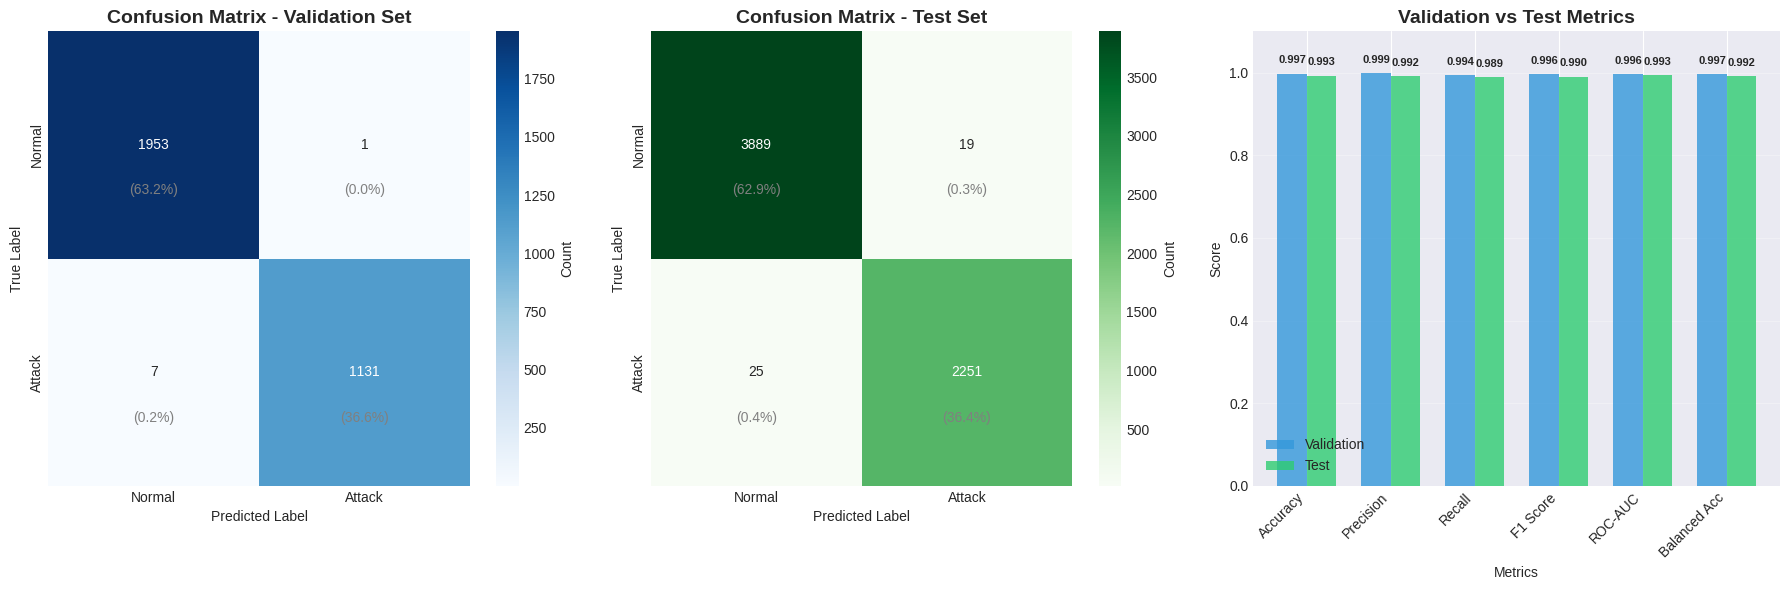

In [25]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'})
for i in range(2):
    for j in range(2):
        percentage = val_cm[i, j] / val_cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                ha='center', va='center', fontsize=10, color='gray')
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 3, 2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'})
for i in range(2):
    for j in range(2):
        percentage = test_cm[i, j] / test_cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                ha='center', va='center', fontsize=10, color='gray')
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 3, 3)
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'Balanced Acc'],
    'Validation': [val_metrics['accuracy'], val_metrics['precision'], val_metrics['recall'],
                   val_metrics['f1_score'], val_metrics['roc_auc'], val_metrics['balanced_accuracy']],
    'Test': [test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'],
             test_metrics['f1_score'], test_metrics['roc_auc'], test_metrics['balanced_accuracy']]
}
comp_df = pd.DataFrame(comparison_data)
x = np.arange(len(comp_df['Metric']))
width = 0.35
plt.bar(x - width/2, comp_df['Validation'], width, label='Validation', color='#3498db', alpha=0.8)
plt.bar(x + width/2, comp_df['Test'], width, label='Test', color='#2ecc71', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Validation vs Test Metrics', fontsize=14, fontweight='bold')
plt.xticks(x, comp_df['Metric'], rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')
for i in range(len(x)):
    plt.text(x[i] - width/2, comp_df['Validation'][i] + 0.02, f"{comp_df['Validation'][i]:.3f}",
             ha='center', va='bottom', fontsize=8, fontweight='bold')
    plt.text(x[i] + width/2, comp_df['Test'][i] + 0.02, f"{comp_df['Test'][i]:.3f}",
             ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

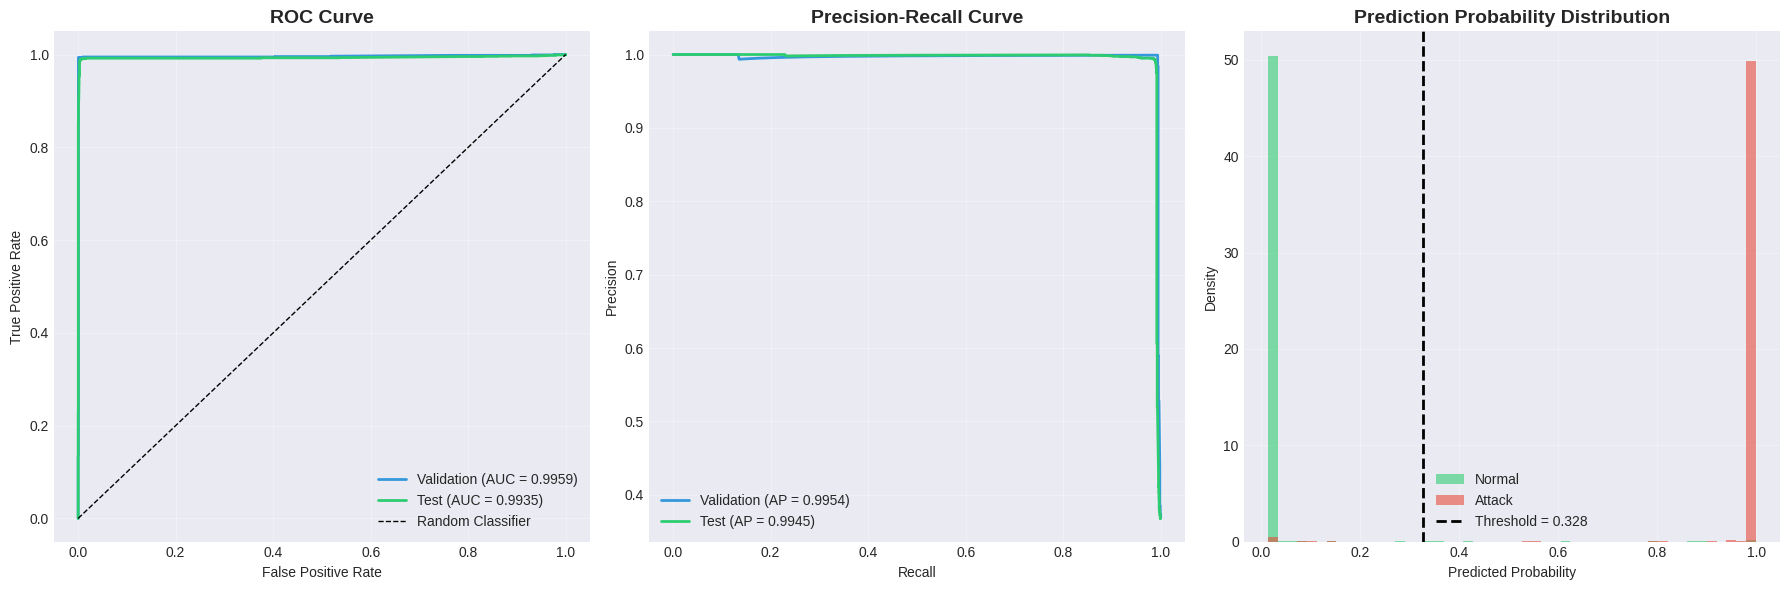

In [26]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_proba_val)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.plot(fpr_val, tpr_val, linewidth=2, label=f'Validation (AUC = {val_metrics["roc_auc"]:.4f})', color='#3498db')
plt.plot(fpr_test, tpr_test, linewidth=2, label=f'Test (AUC = {test_metrics["roc_auc"]:.4f})', color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_pred_proba_val)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
plt.plot(recall_val, precision_val, linewidth=2, label=f'Validation (AP = {val_metrics["average_precision"]:.4f})', color='#3498db')
plt.plot(recall_test, precision_test, linewidth=2, label=f'Test (AP = {test_metrics["average_precision"]:.4f})', color='#2ecc71')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(y_pred_proba_test[y_test==0], bins=50, alpha=0.6, label='Normal', color='#2ecc71', density=True)
plt.hist(y_pred_proba_test[y_test==1], bins=50, alpha=0.6, label='Attack', color='#e74c3c', density=True)
plt.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {optimal_threshold:.3f}')
plt.title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
print("\nClassification Report - Validation Set:")
print(classification_report(y_val, y_pred_val, target_names=['Normal', 'Attack'], digits=4))

print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Attack'], digits=4))


Classification Report - Validation Set:
              precision    recall  f1-score   support

      Normal     0.9964    0.9995    0.9980      1954
      Attack     0.9991    0.9938    0.9965      1138

    accuracy                         0.9974      3092
   macro avg     0.9978    0.9967    0.9972      3092
weighted avg     0.9974    0.9974    0.9974      3092


Classification Report - Test Set:
              precision    recall  f1-score   support

      Normal     0.9936    0.9951    0.9944      3908
      Attack     0.9916    0.9890    0.9903      2276

    accuracy                         0.9929      6184
   macro avg     0.9926    0.9921    0.9923      6184
weighted avg     0.9929    0.9929    0.9929      6184



In [28]:
sample_indices = np.random.choice(len(X_test), 10, replace=False)
sample_predictions = pd.DataFrame({
    'Query': [X_test[i][:80] + '...' if len(X_test[i]) > 80 else X_test[i] for i in sample_indices],
    'True_Label': ['Attack' if y_test[i] == 1 else 'Normal' for i in sample_indices],
    'Predicted_Label': ['Attack' if y_pred_test[i] == 1 else 'Normal' for i in sample_indices],
    'Probability': [f"{y_pred_proba_test[i]:.4f}" for i in sample_indices],
    'Correct': ['✓' if y_test[i] == y_pred_test[i] else '✗' for i in sample_indices]
})

print("\nSample Predictions:")
print(sample_predictions.to_string(index=False))


Sample Predictions:
                                                                              Query True_Label Predicted_Label Probability Correct
                                        select * from stiff order by dollar, steady     Normal          Normal      0.0150       ✓
                                           select * from ( select claws from moon )     Normal          Normal      0.0150       ✓
                                                               grup de la pau, 108,     Normal          Normal      0.0150       ✓
                                                           avenida baraain, 51, 1?h     Normal          Attack      0.9986       ✗
1" ) where 8878 = 8878 or ( select 9173 from ( select count ( * ) ,concat ( 0x71...     Attack          Attack      0.9989       ✓
                                                                           r8cid0va     Normal          Normal      0.0150       ✓
                                        1' ) as lewd where 311

In [29]:
transformer_model.save('sql_injection_transformer_model.keras')
joblib.dump(tokenizer, 'tokenizer.pkl')

model_config = {
    'max_words': MAX_WORDS,
    'max_len': MAX_LEN,
    'vocab_size': VOCAB_SIZE,
    'embed_dim': EMBED_DIM,
    'num_heads': NUM_HEADS,
    'ff_dim': FF_DIM,
    'num_transformer_blocks': NUM_TRANSFORMER_BLOCKS,
    'dropout_rate': DROPOUT_RATE,
    'optimal_threshold': optimal_threshold
}
joblib.dump(model_config, 'model_config.pkl')

evaluation_results = {
    'validation_metrics': val_metrics,
    'test_metrics': test_metrics,
    'validation_cm': val_cm,
    'test_cm': test_cm,
    'history': history.history
}
joblib.dump(evaluation_results, 'evaluation_results.pkl')

preprocessing_artifacts = {
    'max_words': MAX_WORDS,
    'max_len': MAX_LEN,
    'optimal_threshold': optimal_threshold
}
joblib.dump(preprocessing_artifacts, 'preprocessing_artifacts.pkl')

['preprocessing_artifacts.pkl']

In [30]:
def predict_sql_injection(queries, model_path='sql_injection_transformer_model.keras',
                         tokenizer_path='tokenizer.pkl', config_path='preprocessing_artifacts.pkl'):

    model = tf.keras.models.load_model(model_path, custom_objects={
        'TransformerBlock': TransformerBlock,
        'TokenAndPositionEmbedding': TokenAndPositionEmbedding,
        'f1_metric': f1_metric,
        'balanced_accuracy': balanced_accuracy
    })

    tokenizer = joblib.load(tokenizer_path)
    config = joblib.load(config_path)

    if isinstance(queries, str):
        queries = [queries]

    cleaned_queries = [clean_text(q) for q in queries]

    sequences = tokenizer.texts_to_sequences(cleaned_queries)
    padded = pad_sequences(sequences, maxlen=config['max_len'], padding='post', truncating='post')

    probabilities = model.predict(padded).flatten()
    predictions = (probabilities >= config['optimal_threshold']).astype(int)

    results = []
    for i, query in enumerate(queries):
        results.append({
            'query': query[:100] + '...' if len(query) > 100 else query,
            'prediction': 'Attack' if predictions[i] == 1 else 'Normal',
            'probability': float(probabilities[i]),
            'confidence': float(probabilities[i]) if predictions[i] == 1 else float(1 - probabilities[i])
        })

    return results

test_queries = [
    "SELECT * FROM users WHERE id = 1",
    "SELECT * FROM users WHERE id = 1 OR 1=1--",
    "SELECT * FROM products WHERE category = 'electronics'",
    "admin' OR '1'='1",
    "SELECT name, email FROM customers WHERE active = 1",
    "1' UNION SELECT NULL, table_name FROM information_schema.tables--"
]



In [31]:
print("\nTesting Prediction:")
predictions = predict_sql_injection(test_queries)
for pred in predictions:
    print(f"\nQuery: {pred['query']}")
    print(f"Prediction: {pred['prediction']}")
    print(f"Probability: {pred['probability']:.4f}")
    print(f"Confidence: {pred['confidence']:.4f}")


Testing Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Query: SELECT * FROM users WHERE id = 1
Prediction: Normal
Probability: 0.0168
Confidence: 0.9832

Query: SELECT * FROM users WHERE id = 1 OR 1=1--
Prediction: Attack
Probability: 0.9989
Confidence: 0.9989

Query: SELECT * FROM products WHERE category = 'electronics'
Prediction: Normal
Probability: 0.0150
Confidence: 0.9850

Query: admin' OR '1'='1
Prediction: Attack
Probability: 0.9990
Confidence: 0.9990

Query: SELECT name, email FROM customers WHERE active = 1
Prediction: Attack
Probability: 0.4550
Confidence: 0.4550

Query: 1' UNION SELECT NULL, table_name FROM information_schema.tables--
Prediction: Attack
Probability: 0.9990
Confidence: 0.9990


In [32]:
print("SQL INJECTION DETECTION MODEL RESULT")
print(f"\nFinal Test Set Performance:")
print(f"  Accuracy:          {test_metrics['accuracy']:.4f}")
print(f"  Precision:         {test_metrics['precision']:.4f}")
print(f"  Recall:            {test_metrics['recall']:.4f}")
print(f"  F1 Score:          {test_metrics['f1_score']:.4f}")
print(f"  ROC-AUC:           {test_metrics['roc_auc']:.4f}")
print(f"  Balanced Accuracy: {test_metrics['balanced_accuracy']:.4f}")

SQL INJECTION DETECTION MODEL RESULT

Final Test Set Performance:
  Accuracy:          0.9929
  Precision:         0.9916
  Recall:            0.9890
  F1 Score:          0.9903
  ROC-AUC:           0.9935
  Balanced Accuracy: 0.9921
